# Tutorial - Step5 : MTMR evaluation by comparing to SOTA models

## 1. Import requirements

In [1]:
import os
import pandas as pd
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from MTMR.evaluate import evaluate_metric

## 2. Specify a target property

In [3]:
PROPERTY_NAME = "drd2"

## 3. Set directories (for inputs and outputs)

In [4]:
input_data_dir = os.path.join("DATA", PROPERTY_NAME)
input_our_dir = os.path.join("outputs_Tutorial_4_MTMR_translation", PROPERTY_NAME)
input_base_dir = os.path.join("DATA", "baselines")

In [5]:
_output_dir = "outputs_Tutorial_5_MTMR_evaluation"
if not os.path.exists(_output_dir):
    os.mkdir(_output_dir)

output_dir = os.path.join(_output_dir, PROPERTY_NAME)
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

## 4. Set file names

In [6]:
filepath_train_rdkit = os.path.join(input_data_dir, "rdkit_train_pairs.txt")

In [7]:
df_pairs_rdkit = pd.read_csv(filepath_train_rdkit, header=None, sep=" ")
targets_rdkit = set(df_pairs_rdkit.iloc[:,1].values.tolist())

In [8]:
filepath_MTMR  = os.path.join(input_our_dir,  f"MTMR_{PROPERTY_NAME.upper()}.csv")
filepath_JTVAE = os.path.join(input_base_dir, f"JTVAE_{PROPERTY_NAME.upper()}.csv")
filepath_G2G   = os.path.join(input_base_dir, f"VJTNN_{PROPERTY_NAME.upper()}.csv")
filepath_CORE  = os.path.join(input_base_dir, f"CORE_{PROPERTY_NAME.upper()}.csv")
filepath_G2GG  = os.path.join(input_base_dir, f"VJTNN+GAN_{PROPERTY_NAME.upper()}.csv")
filepath_MOLCG = os.path.join(input_base_dir, f"MOLCG_{PROPERTY_NAME.upper()}.csv")
filepath_HIER  = os.path.join(input_base_dir, f"HierG2G_{PROPERTY_NAME.upper()}.csv")
filepath_UGMMT = os.path.join(input_base_dir, f"UGMMT_{PROPERTY_NAME.upper()}.csv")

## 5. Load translation results generated from the test dataset

In [9]:
df_MTMR  = pd.read_csv(filepath_MTMR,  header=None).fillna("").rename(columns={0:"SOURCE", 1:"TARGET", 2:"SIMILARITY", 3:"PROPERTY"})
df_JTVAE = pd.read_csv(filepath_JTVAE, header=None).fillna("").rename(columns={0:"SOURCE", 1:"TARGET", 2:"SIMILARITY", 3:"PROPERTY"})
df_G2G   = pd.read_csv(filepath_G2G,   header=None).fillna("").rename(columns={0:"SOURCE", 1:"TARGET", 2:"SIMILARITY", 3:"PROPERTY"})
df_CORE  = pd.read_csv(filepath_CORE,  header=None).fillna("").rename(columns={0:"SOURCE", 1:"TARGET", 2:"SIMILARITY", 3:"PROPERTY"})
df_G2GG  = pd.read_csv(filepath_G2GG,  header=None).fillna("").rename(columns={0:"SOURCE", 1:"TARGET", 2:"SIMILARITY", 3:"PROPERTY"})
df_HIER  = pd.read_csv(filepath_HIER,  header=None).fillna("").rename(columns={0:"SOURCE", 1:"TARGET", 2:"SIMILARITY", 3:"PROPERTY"})
df_MOLCG = pd.read_csv(filepath_MOLCG, header=None).fillna("").rename(columns={0:"SOURCE", 1:"TARGET", 2:"SIMILARITY", 3:"PROPERTY"})
df_UGMMT = pd.read_csv(filepath_UGMMT, header=None).fillna("").rename(columns={0:"SOURCE", 1:"TARGET", 2:"SIMILARITY", 3:"PROPERTY"})

## 6. Evaluate metrics

In [15]:
frames = []

for i, (name, df) in enumerate([('MTMR', df_MTMR),
                                ('JTVAE', df_JTVAE),
                                ('VJTNN', df_G2G),
                                ('VJTNN+GAN', df_G2GG),
                                ('CORE', df_CORE),
                                ('HierG2G', df_HIER),
                                ('MolCycleGAN', df_MOLCG),
                                ('UGMMT', df_UGMMT)]):
    print(f"NOW: {i}")
    df_metric = evaluate_metric(df, targets_rdkit, num_decode=20,# sample_size=10, start_idx=10,
                                threshold_sim=0.4,
                                threshold_pro=0.5).rename(columns={0:name})

    frames.append(df_metric)

NOW: 0
NOW: 1
NOW: 2
NOW: 3
NOW: 4
NOW: 5
NOW: 6
NOW: 7


In [16]:
df_merged = pd.concat(frames, axis=1).T

In [17]:
df_merged

,VALID_RATIO,AVERAGE_PROPERTY,AVERAGE_SIMILARITY,NOVELTY,SUCCESS,SUCCESS_WO_NOVEL,DIVERSITY
MTMR,1.000,0.799259,0.329498,0.999,0.440,0.445,0.528429
JTVAE,0.924,0.152954,0.444740,0.919,0.135,0.140,0.046200
VJTNN,0.999,0.803339,0.343539,0.696,0.132,0.748,0.315413
VJTNN+GAN,0.999,0.787094,0.323954,0.885,0.199,0.733,0.426588
CORE,0.999,0.799643,0.338479,0.779,0.153,0.759,0.362899
HierG2G,0.981,0.679869,0.257834,0.971,0.126,0.424,0.585500
MolCycleGAN,0.999,0.382074,0.189595,0.983,0.001,0.001,0.049950
UGMMT,0.999,0.737127,0.261423,0.996,0.179,0.213,0.704186


In [18]:
df_merged.to_csv(os.path.join(output_dir, "table_metrics.csv"))

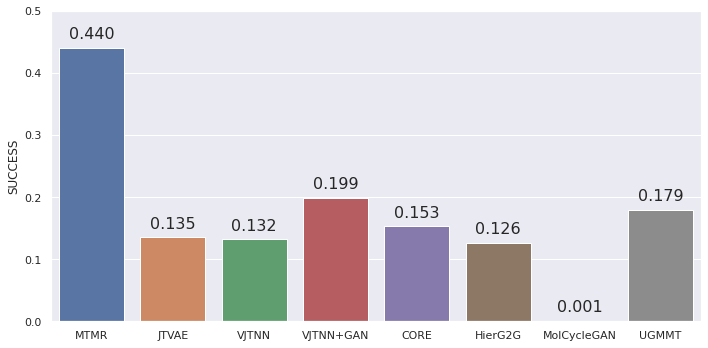

In [19]:
sns.set_theme(style='darkgrid')

fig, ax = plt.subplots(1,1,figsize=(10,5))

#_ = sns.barplot(x=df_merged.index, y=df_merged["SUCCESS"], ax=ax)
_ = sns.barplot(data=df_merged.reset_index(), x='index', y="SUCCESS", ax=ax)

for container in ax.containers:
    for i, bar in enumerate(container.get_children()):
        posx = i
        posy = bar.get_height() + 0.01
        ax.text(posx, posy, f"{bar.get_height():.3f}", rotation=0, ha='center', va='bottom', fontsize=16)

ax.set_xlabel(None)
ax.set_ylim(None, 0.5)
        
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "barplot_success.png"), dpi=300)